In [3]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Prio_n_step_Agent.Prio_DQN_Agent import Prio_DQN_Agent
from Prio_n_step_Agent.utils.random_agent import RandomAgent
from Prio_n_step_Agent.utils.actions import MORE_ACTIONS
import Prio_n_step_Agent.utils.stats_functions as sf
import hockey.hockey_env as h_env

from importlib import reload

In [4]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [5]:
reload(h_env)
env_name = "../weights/prio_agent_self_play_17_2_25"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5, env = env, use_more_actions = USE_MORE_ACTIONS)
agent.Q.load(env_name, name= "episode_2000")

stats, losses = sf.load_stats(env_name)

/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Network loaded from ../weights/prio_agent_self_play_17_2_25/weights/episode_2000.pth


/home/goon/studium/hockey-en-mallorca/src/hockey-env/Prio_n_step_Agent/QFunction.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(f"{env_

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/returns_plot.png


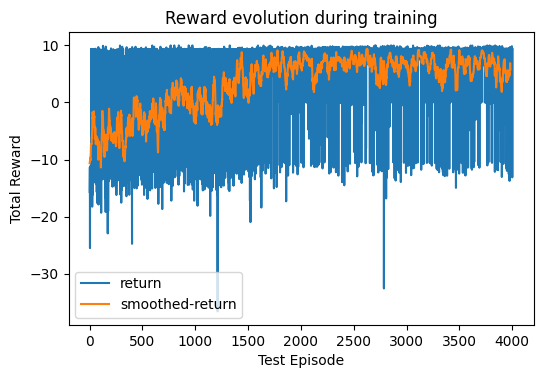

In [6]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/losses_plot.png


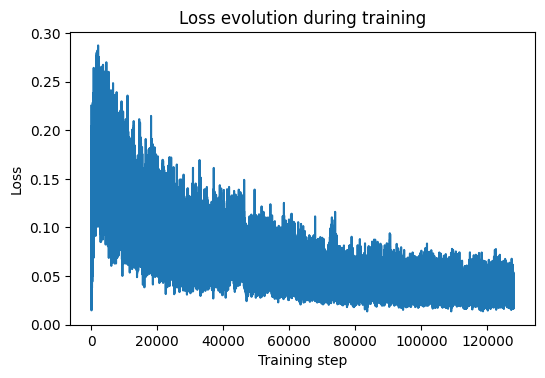

In [7]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/beta_evolution.png


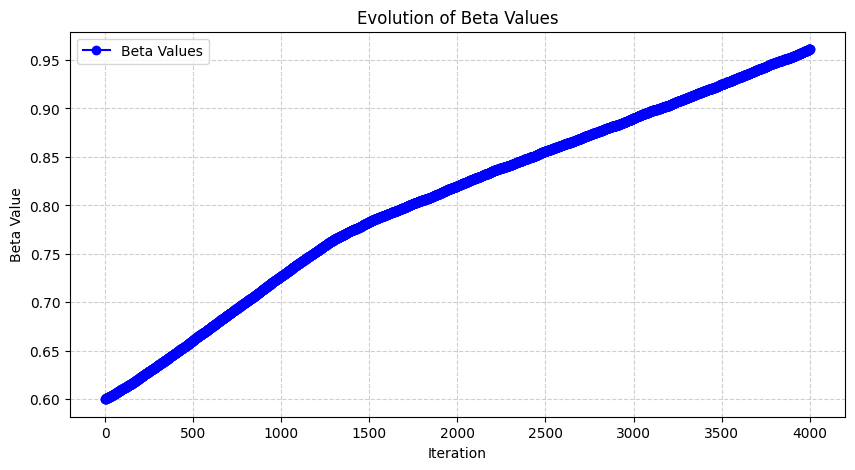

In [8]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/epsilon_evolution.png


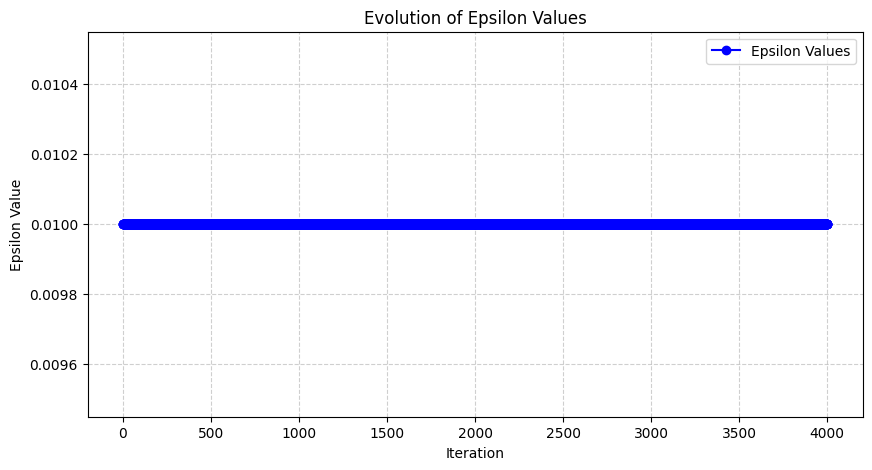

In [9]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/match_evolution.png


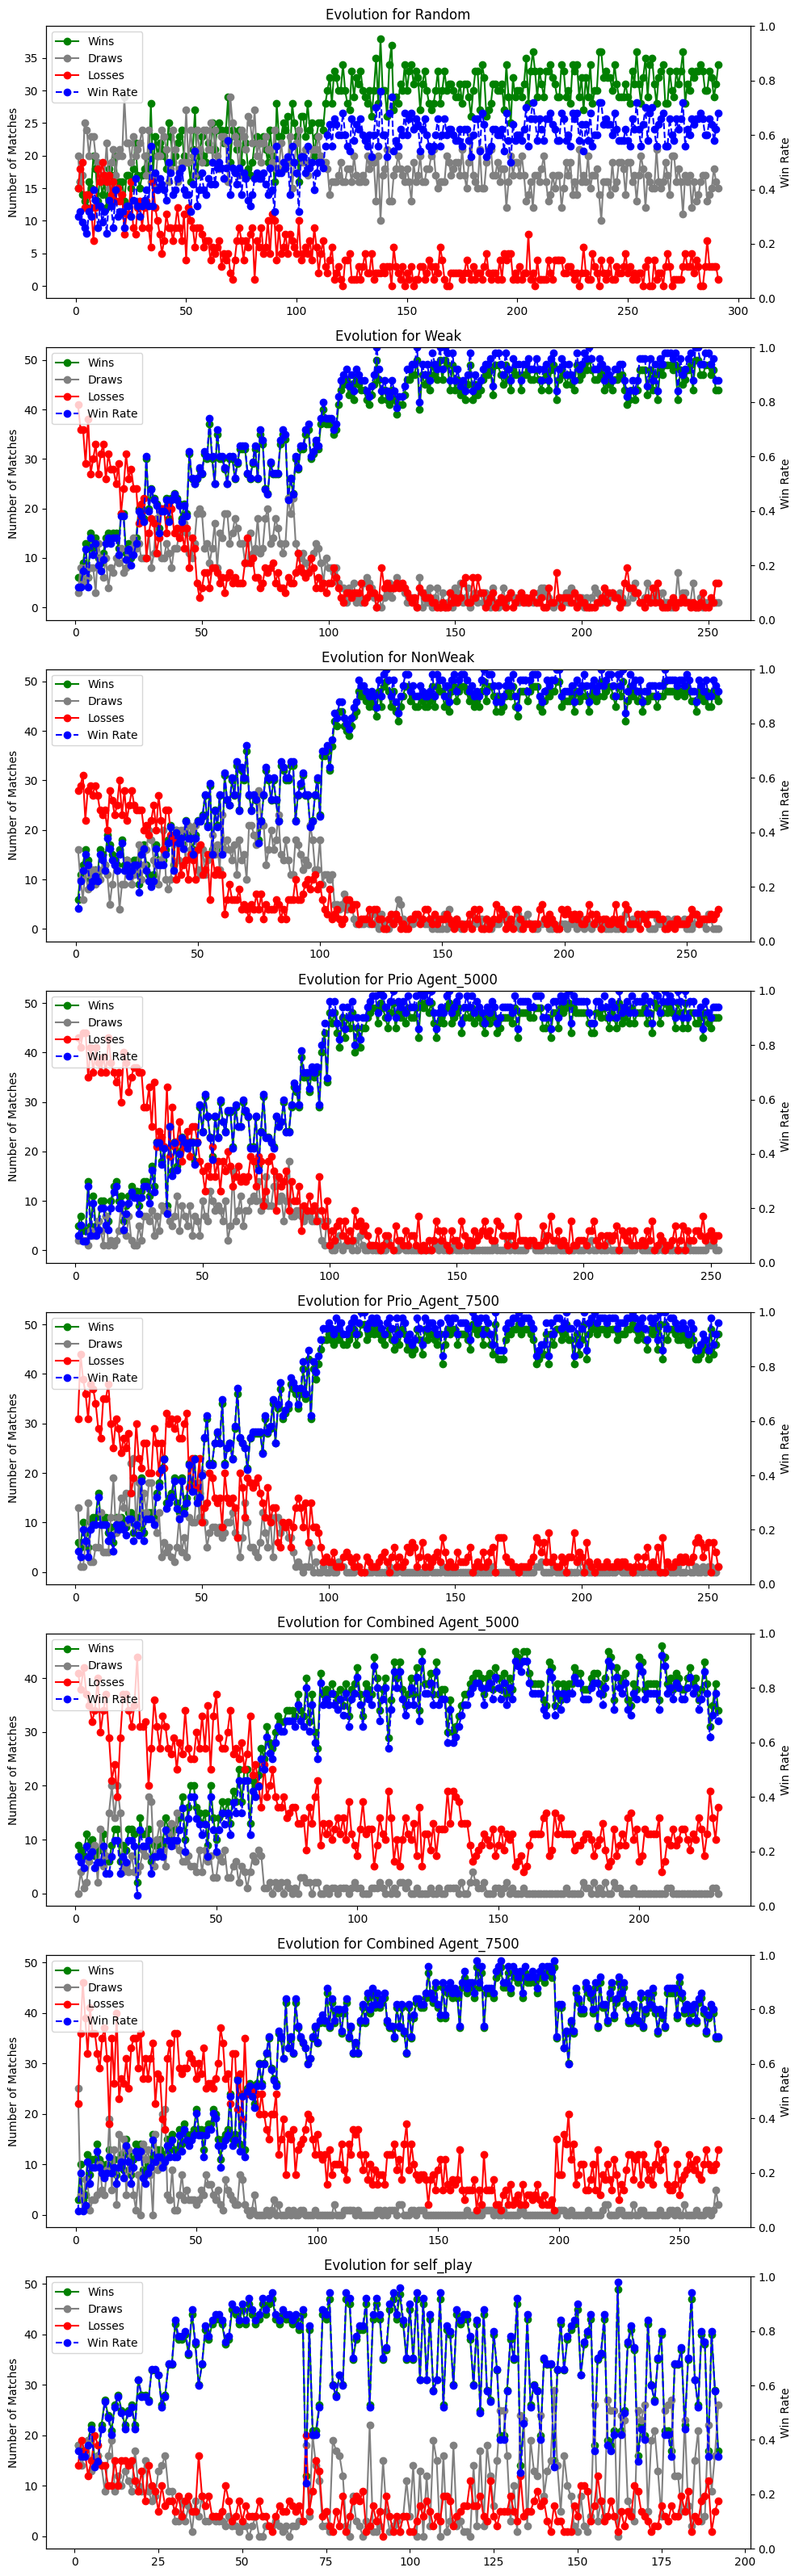

In [10]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history,  [
    "Random",
    "Weak",
    "NonWeak",
    "Prio Agent_5000",
    "Prio_Agent_7500",
    "Combined Agent_5000",
    "Combined Agent_7500",
    "self_play",
], 50)

In [11]:
def test_agent(agent = agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "prio_agent", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  

    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            frame = env.render(mode = "rgb_array")
            if frame is not None:
                frames.append(frame)

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, _ = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        test_rewards.append(total_reward)
        print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    env.close()
    results_name = f"test_results_{test_name}"
    sf.save_test_results(env_name, test_rewards, name = results_name)

Test Episode 1, Total Reward: 8.979815235181357
Test Episode 2, Total Reward: 9.623368716940963
Test Episode 3, Total Reward: 8.176663642228922
Test Episode 4, Total Reward: -1.5822397562424655
Test Episode 5, Total Reward: 0.0
Test Episode 6, Total Reward: 4.042135514007804
Test Episode 7, Total Reward: 0.0
Test Episode 8, Total Reward: 9.333671253894458
Test Episode 9, Total Reward: 8.632256624642617
Test Episode 10, Total Reward: 9.479199543345635
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_random_vs_prio_agent.png


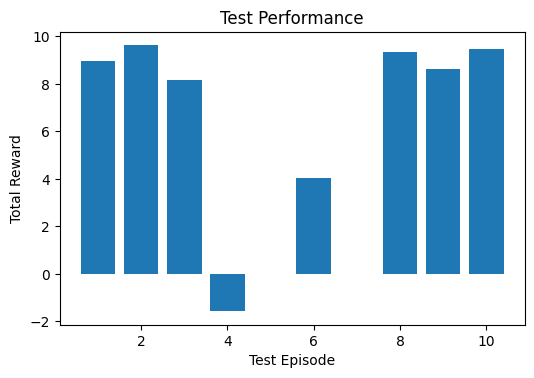

In [12]:
test_agent()

Test Episode 1, Total Reward: 9.613273335204592
Test Episode 2, Total Reward: -11.515793033864362
Test Episode 3, Total Reward: 8.97007423906739
Test Episode 4, Total Reward: 9.082188871750096
Test Episode 5, Total Reward: 9.440758366934572
Test Episode 6, Total Reward: 9.351839579936732
Test Episode 7, Total Reward: 7.080884771464406
Test Episode 8, Total Reward: 9.390558290331905
Test Episode 9, Total Reward: 9.751677954953635
Test Episode 10, Total Reward: 9.466955685642338
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_weak_vs_prio_agent.png


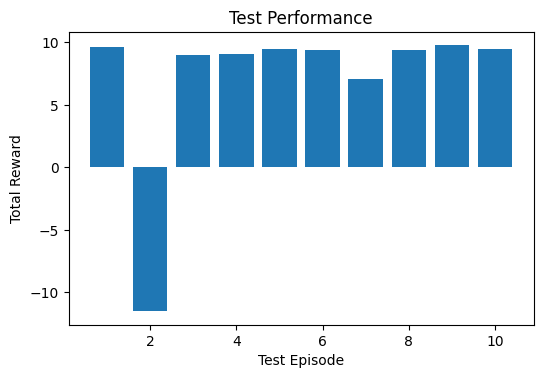

In [13]:
test_agent(opponent = h_env.BasicOpponent(weak=True), opponent_name = "weak", agent_name = "prio_agent")



Test Episode 1, Total Reward: 8.624483176636492
Test Episode 2, Total Reward: -12.157279533488941
Test Episode 3, Total Reward: 8.114726633946658
Test Episode 4, Total Reward: 9.483512058010296
Test Episode 5, Total Reward: 9.000080233423319
Test Episode 6, Total Reward: 8.407672253053757
Test Episode 7, Total Reward: 8.993597624491418
Test Episode 8, Total Reward: 9.289278349047953
Test Episode 9, Total Reward: 6.3863100996319435
Test Episode 10, Total Reward: 8.083011461041512
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_non_weak_vs_prio_agent.png


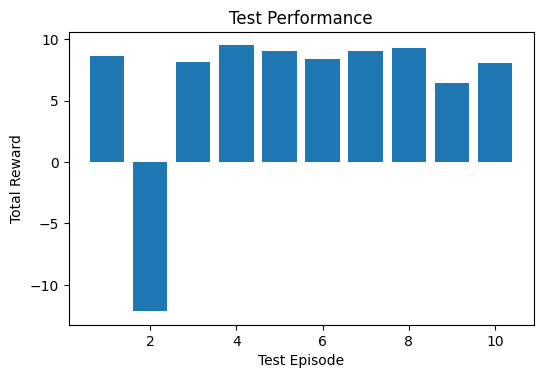

In [14]:
test_agent(opponent = h_env.BasicOpponent(weak=False), opponent_name = "non_weak", agent_name = "prio_agent")

/home/goon/studium/hockey-en-mallorca/src/hockey-env/Prio_n_step_Agent/QFunction.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(f"{env_

Network loaded from ../weights/prio_agent_self_play_17_2_25/weights/episode_1500.pth
Test Episode 1, Total Reward: -10.636985501874861
Test Episode 2, Total Reward: 9.290023837119213
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: 6.18814973522864
Test Episode 5, Total Reward: 9.545071922764858
Test Episode 6, Total Reward: -30.957475288287554
Test Episode 7, Total Reward: -10.648761668893787
Test Episode 8, Total Reward: 9.371333248788961
Test Episode 9, Total Reward: -12.271089240792929
Test Episode 10, Total Reward: -13.955754189336298
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_selfplay.png


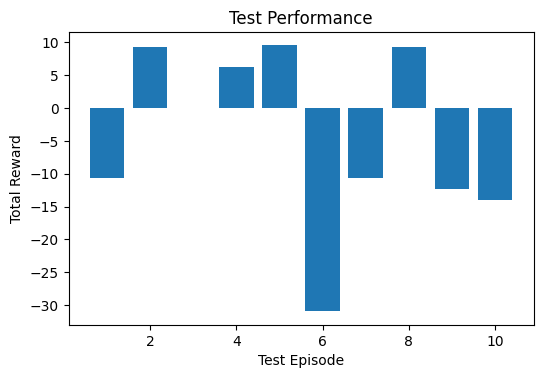

In [15]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)
opponent.Q.load(env_name, name = "episode_1500")

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.perform_greedy_action(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")